# This is a notebook showing the example use case of the erosion and dilation MONAI-compatible dictionary transforms

In [1]:
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy
from monai import transforms as monai_trans
from monai.data import DataLoader,CacheDataset
device = "cuda" if torch.cuda.is_available() else "cpu"

from erosion_dilation import BinaryErosiond, BinaryDilationd

class Error(Exception):
    """Base class for other exceptions"""
    pass

## Sample data from tumour segmentation work, see https://github.com/high-dimensional/tumour-seg

In [2]:
#create a dummy dataset from a single segmentation
paths_enh = sorted(glob.glob('sample_data/*enh*gz'))
paths_nonenh = sorted(glob.glob('sample_data/*net*gz'))
paths_oedema = sorted(glob.glob('sample_data/*oed*gz'))

files = [{"enhancing_seg":u,'nonenhancing_seg': v, "oedema_seg": w} for u, v, w in zip(paths_enh,paths_nonenh,paths_oedema)]
imaging_keys = ['enhancing_seg','nonenhancing_seg','oedema_seg']

z=91 #cut point for plotting

template = nib.load('sample_data/MNI152_T1_1mm.nii.gz')
template = scipy.ndimage.rotate(np.asanyarray(template.dataobj),angle=90)

## Example use in single loader

In [3]:
transforms = [monai_trans.LoadImaged(keys=imaging_keys,dtype=np.float32)]

transforms += [BinaryErosiond(keys=imaging_keys,vary_across_channels=True,prob=.1,random_iteration=True)]
transforms += [BinaryDilationd(keys=imaging_keys,vary_across_channels=True,prob=.1,random_iteration=True)]

transforms = monai_trans.Compose(transforms)

dataset = CacheDataset(data=files, transform=transforms)
loader = DataLoader(dataset, shuffle=False, batch_size=1, drop_last=False,
                        num_workers=0,pin_memory=False)

for batch in loader:
    print("it's as easy as that...")

Loading dataset: 100%|████████████████████████████| 1/1 [00:00<00:00, 11.14it/s]

it's as easy as that...


## Example images across varying degrees of erosion and dilation

Loading dataset: 100%|████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


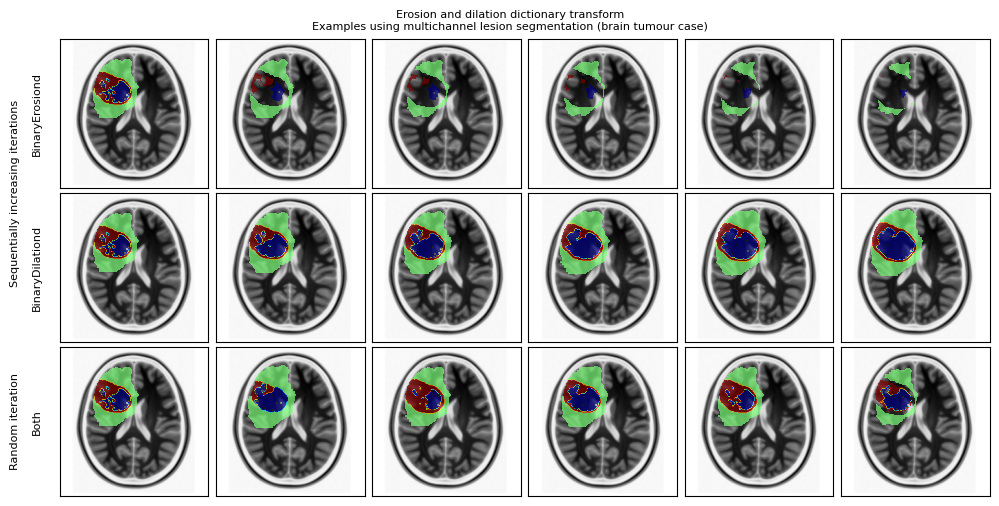

In [4]:
versions = 3
iter_range=6

fig, axes = plt.subplots(nrows=versions, ncols=iter_range,figsize=(iter_range*2,iter_range*2))

#Plot binary erosion with increasing number of interations across all segmentation channels
version_counter=0
for iteration in range(iter_range):
    transforms = [monai_trans.LoadImaged(keys=imaging_keys,dtype=np.float32)]
    if iteration==0:    
        transforms += [BinaryErosiond(keys=imaging_keys,vary_across_channels=False,prob=0,random_iteration=False)]
    else:
        transforms += [BinaryErosiond(keys=imaging_keys,vary_across_channels=False,prob=1,iteration=iteration,random_iteration=False,fill_holes=True)]
    transforms = monai_trans.Compose(transforms)

    dataset = CacheDataset(data=files, transform=transforms)
    loader = DataLoader(dataset, shuffle=False, batch_size=1, drop_last=False,
                            num_workers=0,pin_memory=False)

    for batch in loader:
        enhancing_seg = batch['enhancing_seg'].to(device,non_blocking=True)
        nonenhancing_seg = batch['nonenhancing_seg'].to(device,non_blocking=True)
        oedema_seg = batch['oedema_seg'].to(device,non_blocking=True)

#     heuristic where NET can only exist if there was no enhancing tumour or oedema
#     nonenhancing_seg = nonenhancing_seg - enhancing_seg
#     nonenhancing_seg = torch.where(nonenhancing_seg>0,nonenhancing_seg,0)
    
    #heuristic where ET can only exist if there was no nonenhancing tumour or oedema
    enhancing_seg = enhancing_seg - nonenhancing_seg
    enhancing_seg = torch.where(enhancing_seg>0,enhancing_seg,0)
    
    #heuristic where oedema can only exist if there was no enhancing or nonenhancing tumour
    oedema_seg = oedema_seg - enhancing_seg - nonenhancing_seg
    oedema_seg = torch.where(oedema_seg>0,oedema_seg,0)
    
    if len(torch.unique(oedema_seg+nonenhancing_seg+enhancing_seg)[1:])>3:
        raise Error('Co-existent lesion compartments, something has gone wrong...')

    input_multichannel = np.zeros(shape=oedema_seg.shape[1:])
    input_multichannel[enhancing_seg[0,:,:,:].cpu().numpy().nonzero()]=3 #enhancing tumour
    input_multichannel[nonenhancing_seg[0,:,:,:].cpu().numpy().nonzero()]=1 #nonenhancing tumour
    input_multichannel[oedema_seg[0,:,:,:].cpu().numpy().nonzero()]=2 #oedema
    input_multichannel = scipy.ndimage.rotate(input_multichannel,angle=90)
    input_multichannel_masked = np.ma.masked_where(input_multichannel < 1, input_multichannel)

    axes[version_counter,iteration].imshow(template[:,:,z],cmap='Greys')
    axes[version_counter,iteration].imshow(input_multichannel_masked[:,:,z],alpha=0.7,vmin=1,vmax=3,cmap='jet',interpolation=None)

version_counter+=1
#Plot binary dilation with increasing number of interations across all segmentation channels
for iteration in range(iter_range):
    transforms = [monai_trans.LoadImaged(keys=imaging_keys,dtype=np.float32)]
    if iteration==0:    
        transforms += [BinaryDilationd(keys=imaging_keys,vary_across_channels=False,prob=0,random_iteration=False)]
    else:
        transforms += [BinaryDilationd(keys=imaging_keys,vary_across_channels=False,prob=1,iteration=iteration,random_iteration=False,fill_holes=True)]
    transforms = monai_trans.Compose(transforms)

    dataset = CacheDataset(data=files, transform=transforms)
    loader = DataLoader(dataset, shuffle=False, batch_size=1, drop_last=False,
                            num_workers=0,pin_memory=False)

    for batch in loader:
        enhancing_seg = batch['enhancing_seg'].to(device,non_blocking=True)
        nonenhancing_seg = batch['nonenhancing_seg'].to(device,non_blocking=True)
        oedema_seg = batch['oedema_seg'].to(device,non_blocking=True)

    #heuristic where NET can only exist if there was no enhancing tumour or oedema
#     nonenhancing_seg = nonenhancing_seg - enhancing_seg
#     nonenhancing_seg = torch.where(nonenhancing_seg>0,nonenhancing_seg,0)
    
    #heuristic where ET can only exist if there was no nonenhancing tumour or oedema
    enhancing_seg = enhancing_seg - nonenhancing_seg
    enhancing_seg = torch.where(enhancing_seg>0,enhancing_seg,0)
    
    #heuristic where oedema can only exist if there was no enhancing or nonenhancing tumour
    oedema_seg = oedema_seg - enhancing_seg - nonenhancing_seg
    oedema_seg = torch.where(oedema_seg>0,oedema_seg,0)
    
    if len(torch.unique(oedema_seg+nonenhancing_seg+enhancing_seg)[1:])>3:
        raise Error('Co-existent lesion compartments, something has gone wrong...')

    input_multichannel = np.zeros(shape=oedema_seg.shape[1:])
    input_multichannel[enhancing_seg[0,:,:,:].cpu().numpy().nonzero()]=3 #enhancing tumour
    input_multichannel[nonenhancing_seg[0,:,:,:].cpu().numpy().nonzero()]=1 #nonenhancing tumour
    input_multichannel[oedema_seg[0,:,:,:].cpu().numpy().nonzero()]=2 #oedema
    input_multichannel = scipy.ndimage.rotate(input_multichannel,angle=90)
    input_multichannel_masked = np.ma.masked_where(input_multichannel < 1, input_multichannel)

    axes[version_counter,iteration].imshow(template[:,:,z],cmap='Greys')
    axes[version_counter,iteration].imshow(input_multichannel_masked[:,:,z],alpha=0.7,vmin=1,vmax=3,cmap='jet',interpolation=None)

    
version_counter+=1
#Plot binary dilation and erosion with variable number of interations across all segmentation channels
for iteration in range(iter_range):
    transforms = [monai_trans.LoadImaged(keys=imaging_keys,dtype=np.float32)]
    if iteration==0:    
        transforms += [BinaryDilationd(keys=imaging_keys,vary_across_channels=True,prob=0,random_iteration=True)]
        transforms += [BinaryErosiond(keys=imaging_keys,vary_across_channels=True,prob=0,random_iteration=True)]
    else:
        transforms += [BinaryDilationd(keys=imaging_keys,vary_across_channels=True,prob=1,random_iteration=True,verbose=False,seed=np.random.randint(99),fill_holes=True)]
        transforms += [BinaryErosiond(keys=imaging_keys,vary_across_channels=True,prob=1,random_iteration=True,seed=np.random.randint(99),fill_holes=True)]
    transforms = monai_trans.Compose(transforms)

    dataset = CacheDataset(data=files, transform=transforms)
    loader = DataLoader(dataset, shuffle=False, batch_size=1, drop_last=False,
                            num_workers=0,pin_memory=False)
    for batch in loader:
        enhancing_seg = batch['enhancing_seg'].to(device,non_blocking=True)
        nonenhancing_seg = batch['nonenhancing_seg'].to(device,non_blocking=True)
        oedema_seg = batch['oedema_seg'].to(device,non_blocking=True)

    #heuristic where NET can only exist if there was no enhancing tumour or oedema
#     nonenhancing_seg = nonenhancing_seg - enhancing_seg
#     nonenhancing_seg = torch.where(nonenhancing_seg>0,nonenhancing_seg,0)

    #heuristic where ET can only exist if there was no nonenhancing tumour or oedema
    enhancing_seg = enhancing_seg - nonenhancing_seg
    enhancing_seg = torch.where(enhancing_seg>0,enhancing_seg,0)
    
    #heuristic where oedema can only exist if there was no enhancing or nonenhancing tumour
    oedema_seg = oedema_seg - enhancing_seg - nonenhancing_seg
    oedema_seg = torch.where(oedema_seg>0,oedema_seg,0)
    
    if len(torch.unique(oedema_seg+nonenhancing_seg+enhancing_seg)[1:])>3:
        raise Error('Co-existent lesion compartments, something has gone wrong...')

    input_multichannel = np.zeros(shape=oedema_seg.shape[1:])
    input_multichannel[enhancing_seg[0,:,:,:].cpu().numpy().nonzero()]=3 #enhancing tumour
    input_multichannel[nonenhancing_seg[0,:,:,:].cpu().numpy().nonzero()]=1 #nonenhancing tumour
    input_multichannel[oedema_seg[0,:,:,:].cpu().numpy().nonzero()]=2 #oedema
    input_multichannel = scipy.ndimage.rotate(input_multichannel,angle=90)
    input_multichannel_masked = np.ma.masked_where(input_multichannel < 1, input_multichannel)
    
    axes[version_counter,iteration].imshow(template[:,:,z],cmap='Greys')
    axes[version_counter,iteration].imshow(input_multichannel_masked[:,:,z],alpha=0.7,vmin=1,vmax=3,cmap='jet',interpolation=None)

    
for row in axes:
    for col in row:
        col.set_box_aspect(1)

        col.set_xticks([])
        col.set_yticks([])
        
plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=-0.75)

plt.text(-0.3,1,'Sequentially increasing iterations',rotation=90,transform=axes[1,0].transAxes,horizontalalignment='center',verticalalignment='center',fontsize=iter_range+2)
plt.text(-0.3,0.5,'Random iteration',rotation=90,transform=axes[2,0].transAxes,horizontalalignment='center',verticalalignment='center',fontsize=iter_range+2)

plt.text(-0.15,0.5,'BinaryErosiond',rotation=90,transform=axes[0,0].transAxes,horizontalalignment='center',verticalalignment='center',fontsize=iter_range+2)
plt.text(-0.15,0.5,'BinaryDilationd',rotation=90,transform=axes[1,0].transAxes,horizontalalignment='center',verticalalignment='center',fontsize=iter_range+2)
plt.text(-0.15,0.5,'Both',rotation=90,transform=axes[2,0].transAxes,horizontalalignment='center',verticalalignment='center',fontsize=iter_range+2)

st = plt.suptitle('Erosion and dilation dictionary transform\nExamples using multichannel lesion segmentation (brain tumour case)', fontsize=iter_range+2)
st.set_y(0.71)

plt.savefig("sample_image.png",dpi=600,bbox_inches='tight')